# Code zu der Arbeit:
# "Comparitve Study von Machine Learning Modellen zur Erkennung von Web Schwachstellen"
## von Nils Pudenz

In [ ]:

%pip install kaggle scikit-learn xgboost catboost tabpfn pandas numpy matplotlib seaborn -q
%pip install --quiet scikit-learn xgboost catboost tabpfn chardet
%pip install -U scikit-learn
## in deiner (Conda/venv) Umgebung
%pip install --upgrade "torch==2.*" --index-url https://download.pytorch.org/whl/cu121
%pip install --upgrade xgboost catboost scikit-learn pandas scipy tabpfn
##wenn es komplikationen mit torch gibt, deiinstallieren und neu installieren
#%pip uninstall torch
%pip install torch --index-url https://download.pytorch.org/whl/cu121 --upgrade
%pip install openpyxl
%pip install XlsxWriter
%pip install openpyxl

## Check ob GPU verwendet werden kann

In [1]:
import sys
import torch

print(sys.version)
print("Python:", sys.executable)
print("Torch:", torch.__version__, "| CUDA build:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Python: c:\Users\nilsp\Github_Desktop\Machine-Learning-Modellen-zur-Erkennung-von-Web-Schwachstellen\.venv\Scripts\python.exe
Torch: 2.6.0+cu124 | CUDA build: 12.4
CUDA available: True


In [2]:
import sys, os, torch, platform
print("Python:", sys.executable)
print("Torch:", torch.__version__, "| Torch CUDA build:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "—")


Python: c:\Users\nilsp\Github_Desktop\Machine-Learning-Modellen-zur-Erkennung-von-Web-Schwachstellen\.venv\Scripts\python.exe
Torch: 2.6.0+cu124 | Torch CUDA build: 12.4
CUDA available: True
CUDA_VISIBLE_DEVICES: None
Device count: 1
Device name: NVIDIA GeForce RTX 2060 SUPER


## Dowload Kaggle Datasets
Requires Kaggle API credentials ('~/.kaggle/kaggle.json') für API-Token, um zugriff auf die Datenbanken über das Kaggle Konto zu bekommen

In [3]:
from pathlib import Path


DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

In [4]:
#Dowload der Datasets von Kaggle, Output = 0 erfolgreich, Output = 1 fehlerhaft
import os


os.system("kaggle datasets download -d syedsaqlainhussain/sql-injection-dataset -p data --unzip --quiet")
os.system("kaggle datasets download -d syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning -p data --unzip --quiet")

0

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

def kaggle_download(dataset, path="data", unzip=True):
    api = KaggleApi()
    api.authenticate() #nutzt ~/.kaggle/kaggle.json für Authentifizierung oder Environment-Variablen
    api.dataset_download_files(dataset, path=path, unzip=unzip)
    print(f"Downloaded {dataset}")

kaggle_download("syedsaqlainhussain/sql-injection-dataset")#, path=DATA_DIR, unzip=True)
kaggle_download("syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning")#, path=DATA_DIR, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/syedsaqlainhussain/sql-injection-dataset
Downloaded syedsaqlainhussain/sql-injection-dataset
Dataset URL: https://www.kaggle.com/datasets/syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning
Downloaded syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning


In [6]:
import pandas as pd

sql_df = pd.read_csv("data/SQLiV3.csv", encoding="utf-8", low_memory=False)
xss_df = pd.read_csv("data/XSS_dataset.csv", encoding="utf-8", low_memory=False)

## Infos über den Datensatz

In [47]:
# Spalten ansehen
print(sql_df.columns.tolist())

# Typische Index-/Hilfsspalten loswerden
sql_df = sql_df.loc[:, ~sql_df.columns.str.contains(r"^Unnamed|^index$", case=False)]

# Auf die Kernspalten reduzieren (falls etwas anderes drin ist)
sql_df = sql_df[["Sentence", "Label"]].copy()

# Optional: Duplikate auf Satzebene entfernen (falls noch nicht passiert)
sql_df = sql_df.drop_duplicates(subset=["Sentence"]).reset_index(drop=True)

print("clean shape:", sql_df.shape)  # Erwartung: (30873, 2)
print(sql_df["Label"].value_counts(normalize=True))

# Spalten ansehen
print(xss_df.columns.tolist())

# Typische Index-/Hilfsspalten entfernen
xss_df = xss_df.loc[:, ~xss_df.columns.str.contains(r"^Unnamed|^index$", case=False)]

# Auf Kernspalten reduzieren (robust, falls Namen leicht abweichen)
cols_lower = {c.lower(): c for c in xss_df.columns}

# Text-/Label-Spalten finden
text_candidates  = ["sentence", "text", "payload", "request", "content"]
label_candidates = ["label", "class", "target"]

sent_col  = cols_lower.get("sentence") or next((cols_lower[c] for c in text_candidates  if c in cols_lower), None)
label_col = cols_lower.get("label")    or next((cols_lower[c] for c in label_candidates if c in cols_lower), None)

if sent_col is None or label_col is None:
    raise KeyError(
        f"Konnte Text-/Labelspalten nicht finden. Verfügbare Spalten: {list(xss_df.columns)}"
    )

# Vereinheitlichen auf 'Sentence' / 'Label'
xss_df = xss_df[[sent_col, label_col]].rename(columns={sent_col: "Sentence", label_col: "Label"}).copy()

# Optional: Duplikate auf Satzebene entfernen
xss_df = xss_df.drop_duplicates(subset=["Sentence"]).reset_index(drop=True)

print("clean shape:", xss_df.shape)
print(xss_df["Label"].value_counts(normalize=True))



['Sentence', 'Label']
clean shape: (30873, 2)
Label
0                                                                         0.623717
1                                                                         0.367117
0                                                                         0.008227
 --                                                                       0.000356
waitfor delay '0:0:__TIME__'--                                            0.000130
 DROP TABLE Suppliers                                                     0.000065
 desc users                                                               0.000032
SELECT *                                                                  0.000032
 OR                                                                       0.000032
 if not  (  select system_user  )   <> 'sa' waitfor delay '0:0:2' --      0.000032
 drop table temp --                                                       0.000032
 grant resource to name            

In [8]:
for name, df in {"SQL": sql_df, "XSS": xss_df}.items():
    print(f"{name} dataset shape: {df.shape}")
    display(df.head(20))
    display(df.tail(20))
    display(df.describe())
    display(df.info())

SQL dataset shape: (30873, 2)


,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,NaN
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
5,select name from syscolumns where id = ...,1
6,select * from users where id = 1 +$+ or 1 =...,1
7,"1; ( load_file ( char ( 47,101,116,99,47...",1
8,select * from users where id = '1' or ||/1 ...,1
9,select * from users where id = '1' or \.<\ ...,1


,Sentence,Label
30853,SELECT * FROM claws WHERE mountain = 'steam' ...,0
30854,SELECT * FROM thread WHERE NOT eleven = 'wo...,0
30855,SELECT * FROM held WHERE continued = 'balloon'...,0
30856,SELECT * FROM clothes WHERE NOT dear = 'deal' ...,0
30857,SELECT * FROM main ORDER BY nearby,0
30858,SELECT * FROM throat ORDER BY cake DESC,0
30859,"SELECT * FROM balloon ORDER BY climate, mostly",0
30860,"SELECT * FROM write ORDER BY nation ASC, simp...",0
30861,"INSERT INTO chair ( answer, action, pictured, ...",0
30862,"INSERT INTO boy ( goose, offer, slabs ) VALU...",0


,Sentence,Label
count,30872,30619
unique,30872,17
top,""" or pg_sleep ( __TIME__ ) --",0
freq,1,19256


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30873 entries, 0 to 30872
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  30872 non-null  object
 1   Label     30619 non-null  object
dtypes: object(2)
memory usage: 482.5+ KB


None

XSS dataset shape: (10917, 2)


,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0
5,"<li id=""cite_note-118""><span class=""mw-cite-ba...",0
6,"<li><a href=""/wiki/Contextualism"" title=""Conte...",0
7,"<li id=""cite_note-Representing_causation-95""><...",0
8,"<tr><td class=""plainlist"" style=""padding:0 0....",0
9,\t </span>,0


,Sentence,Label
10897,<style>:target {color:red;}</style><section id...,1
10898,<style>@keyframes slidein {}</style><details s...,1
10899,"<frameset onmouseleave=""alert(1)"">test</frameset>",1
10900,"<ruby draggable=""true"" ondragleave=""alert(1)"">...",1
10901,"<abbr ondblclick=""alert(1)"">test</abbr>",1
10902,"<li><a href=""/wiki/Articulated_robot"" title=""A...",0
10903,"<tt onclick=""alert(1)"">test</tt>",1
10904,<table id=x tabindex=1 onbeforeactivate=alert(...,1
10905,"<multicol onbeforepaste=""alert(1)"" contentedit...",1
10906,<style>@keyframes slidein {}</style><optgroup ...,1


,Label
count,10917.000000
mean,0.670789
std,0.469948
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10917 entries, 0 to 10916
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  10917 non-null  object
 1   Label     10917 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 170.7+ KB


None

In [ ]:
# Plots Speichern
import matplotlib.pyplot as plt
from pathlib import Path



SQL Distribution:
Klassenverteilung:
Label
0                                                                         0.623717
1                                                                         0.367117
0                                                                         0.008227
 --                                                                       0.000356
waitfor delay '0:0:__TIME__'--                                            0.000130
 DROP TABLE Suppliers                                                     0.000065
 desc users                                                               0.000032
SELECT *                                                                  0.000032
 OR                                                                       0.000032
 if not  (  select system_user  )   <> 'sa' waitfor delay '0:0:2' --      0.000032
 drop table temp --                                                       0.000032
 grant resource to name                     

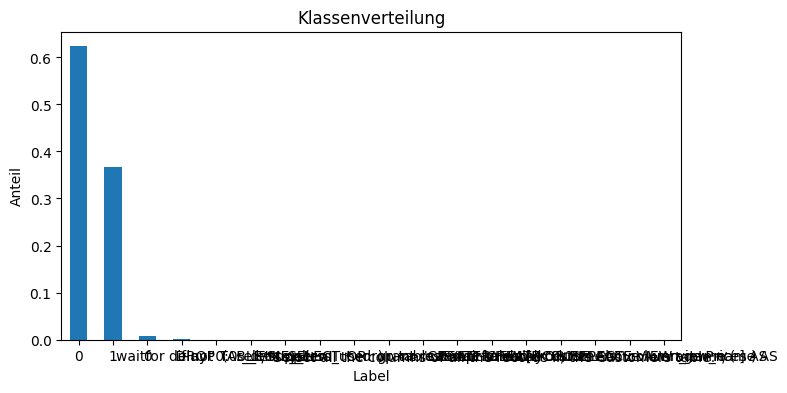

None
XSS Distribution:
Klassenverteilung:
Label
1    0.670789
0    0.329211
Name: proportion, dtype: float64


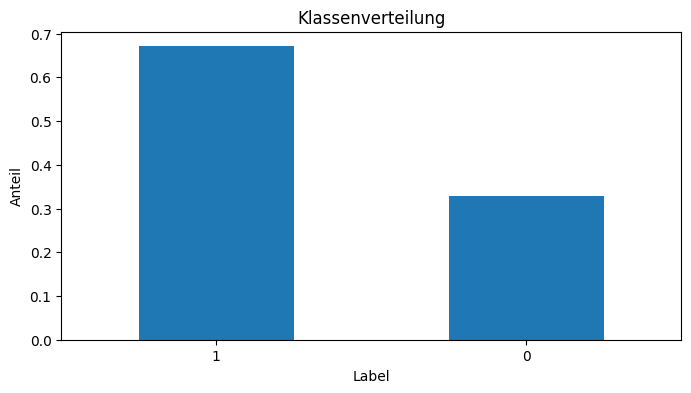

None


In [ ]:
import matplotlib.pyplot as plt

def class_distribution(df, label_col="Label"):
    """Zeigt die Klassenverteilung in einem DataFrame."""
    counts = df[label_col].value_counts(normalize=True)
    print("Klassenverteilung:")
    print(counts)
    plt.figure(figsize=(8, 4))
    counts.plot(kind="bar")
    plt.title("Klassenverteilung")
    plt.xlabel(label_col)
    plt.ylabel("Anteil")
    plt.xticks(rotation=0)
    plt.show()

print("SQL Distribution:")
print(class_distribution(sql_df, "Label"))

print("XSS Distribution:")
print(class_distribution(xss_df, "Label"))

## Basic Cleaning
* Drop Duplicate rows
* Handle missing values (simple fill-na)

In [10]:
for df in (sql_df, xss_df):
    df.drop_duplicates(inplace=True)
    df.fillna(0, inplace=True)

In [11]:
def preprocess_xy(df: pd.DataFrame,
                  label_candidates=("label", "class", "target"),
                  label_map=None):
    if label_map is None:
        label_map = {
            "0": "0", "1": "1",
            "benign": "0", "normal": "0", "legitimate": "0", "safe": "0",
            "attack": "1", "malicious": "1", "sql injection": "1",
            "sql-injection": "1", "xss": "1"
        }

    # Zielspalte finden (im *übergebenen* df!)
    cols_lower = {c.lower(): c for c in df.columns}
    target_col = next((cols_lower[c] for c in label_candidates if c in cols_lower), None)
    if target_col is None:
        raise ValueError(f"Keine Label-Spalte gefunden. Kandidaten: {label_candidates}")

    # Labels normieren -> nur 0/1 behalten
    y_str = df[target_col].astype(str).str.strip().str.lower()
    y_map = y_str.map(label_map)
    mask = y_map.notna()
    y = pd.to_numeric(y_map[mask]).astype(int).to_numpy()

    # Rohtext aus allen Nicht-Label-Spalten zusammenbauen
    feat_cols = [c for c in df.columns if c != target_col]
    X_raw = df.loc[mask, feat_cols].astype(str).agg(" ".join, axis=1)

    return X_raw, y, target_col


# Globale Settings

In [12]:

#Deterministische Ausgabe generieren, um die Reproduzierbarkeit zu gewährleisten
RANDOM_STATE = 42

os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
torch.set_num_threads(8)

USE_CUDA = torch.cuda.is_available()  # für TabPFN & XGBoost

# Hilfsfunktionen 

In [13]:
import time
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def binary_metrics(y_true, y_pred) -> dict:
    """Präzision/Recall/F1 & Raten (FPR/FNR) für binäre Klassifikation."""
    y_pred = np.asarray(y_pred).ravel()
    p  = precision_score(y_true, y_pred)
    r  = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = float(fp / (fp + tn)) if (fp + tn) else 0.0
    fnr = float(fn / (fn + tp)) if (fn + tp) else 0.0
    return dict(Precision=p, Recall=r, F1=f1, FPR=fpr, FNR=fnr)

def evaluate_model(model, X_test, y_test, name, use_batches=False, batch_size=256) -> dict: #Dictionary für Evaluierungsmetriken
    """Zeitmessung + Vorhersage (optional in Batches) + Metriken."""
    print(f"→ Evaluate {name} on X_test={getattr(X_test,'shape',None)}")
    t0 = time.perf_counter()
    if use_batches:
        y_pred = predict_in_batches(model, X_test, batch_size=batch_size, verbose=True)
    else:
        y_pred = model.predict(X_test)
    pred_s = time.perf_counter() - t0
    m = binary_metrics(y_test, y_pred)
    res = dict(Model=name, Pred_s=pred_s, **m)
    return res

In [14]:
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """Zeigt eine Konfusionsmatrix an."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() / 2
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i, j], horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Preprocessing

### Batchweise Vorhersage für TabPFN

In [15]:

import math
def predict_in_batches(model, X, batch_size=256, verbose=False):
    """Vorhersage in Batches (schont RAM/VRAM; wichtig für TabPFN)."""
    n = X.shape[0]
    out = []
    total = math.ceil(n / batch_size)
    for b, i in enumerate(range(0, n, batch_size), start=1):
        j = min(i + batch_size, n)
        t1 = time.perf_counter()
        with torch.inference_mode():
            out.append(model.predict(X[i:j]))
        dt = time.perf_counter() - t1
        if verbose:
            print(f"   [predict] batch {b:>3}/{total} ({j-i} rows) in {dt:.2f}s")
        if USE_CUDA:
            torch.cuda.synchronize()
    return np.concatenate(out)

### Label bereinigung der Datensets

In [16]:
def clean_labels(df, label_col="Label", text_cols=("Sentence",)):
    """Bringt Labels robust auf {0,1} und gibt (X_raw, y) zurück."""
    df = df.copy()
    
    # Labels in {0,1} umwandeln
    y_raw = df[label_col].astype(str).str.strip().str.lower()
    map01 = {
        "0": "0", "1": "1", "benign": "0", "normal": "0", "legitimate": "0", "safe": "0",
        "attack": "1", "malicious": "1", "sql injection": "1", "sql-injection": "1", "xss": "1"
    }
    y_map = y_raw.map(map01)
    mask = y_map.notna()
    y = pd.to_numeric(y_map[mask]).astype(int).to_numpy()
    
    # Explizit nur angegebene Textspalten verwenden!
    X_raw = df.loc[mask, text_cols].astype(str).agg(" ".join, axis=1)
    
    return X_raw, y

## Split

In [17]:
from sklearn.model_selection import train_test_split

# Falls clean_labels(X) bereits (Rohtext, y) zurückgibt:
X_txt_sql, y_sql = clean_labels(sql_df, label_col="Label", text_cols=("Sentence",))
X_train_sql, X_test_sql, y_train_sql, y_test_sql = train_test_split(
    X_txt_sql, y_sql, test_size=0.2, stratify=y_sql, random_state=RANDOM_STATE
)

X_txt_xss, y_xss = clean_labels(xss_df, label_col="Label", text_cols=("Sentence",))
X_train_xss, X_test_xss, y_train_xss, y_test_xss = train_test_split(
    X_txt_xss, y_xss, test_size=0.2, stratify=y_xss, random_state=RANDOM_STATE
)

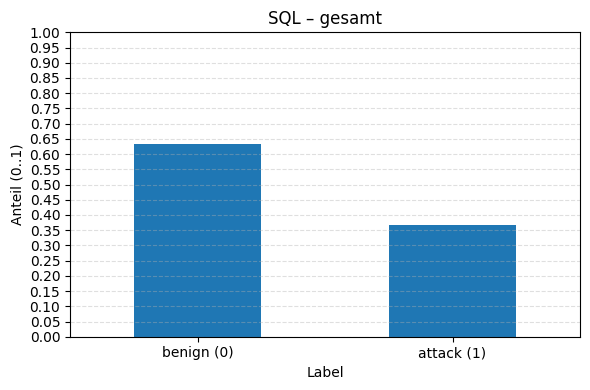

N=30844 | 0 (harmlos): 19510, 1 (bösartig): 11334 | 63,25% harmlos (0), 36,75% bösartig (1)


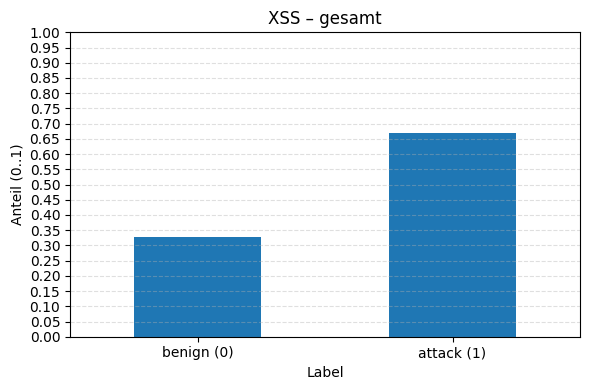

N=10917 | 0 (harmlos): 3594, 1 (bösartig): 7323 | 32,92% harmlos (0), 67,08% bösartig (1)


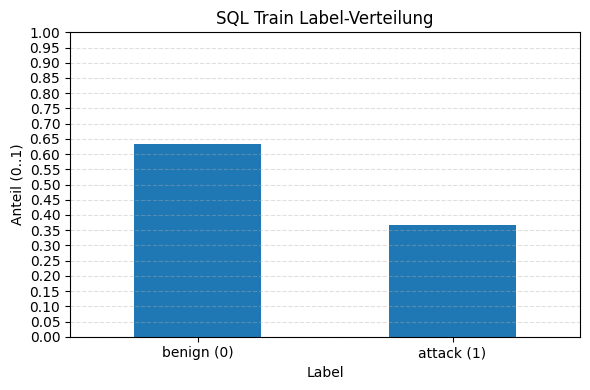

N=24675 | 0 (harmlos): 15608, 1 (bösartig): 9067 | 63,25% harmlos (0), 36,75% bösartig (1)


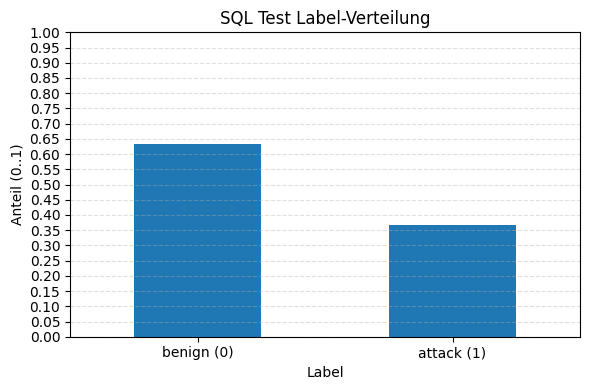

N=6169 | 0 (harmlos): 3902, 1 (bösartig): 2267 | 63,25% harmlos (0), 36,75% bösartig (1)


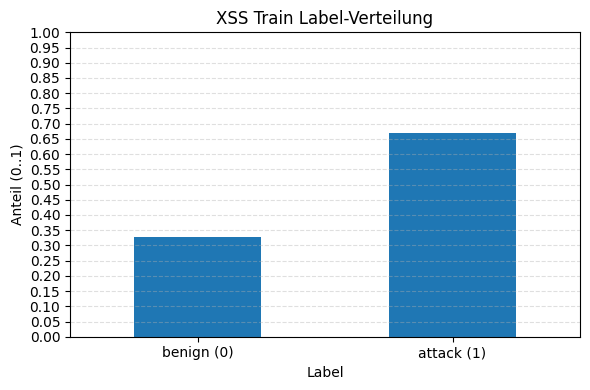

N=8733 | 0 (harmlos): 2875, 1 (bösartig): 5858 | 32,92% harmlos (0), 67,08% bösartig (1)


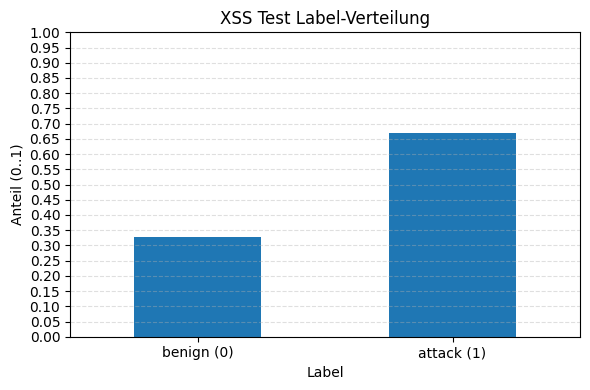

N=2184 | 0 (harmlos): 719, 1 (bösartig): 1465 | 32,92% harmlos (0), 67,08% bösartig (1)


{'N': 2184,
 'n0': 719,
 'n1': 1465,
 'p0': 32.92124542124542,
 'p1': 67.07875457875457,
 'text': 'N=2184 | 0 (harmlos): 719, 1 (bösartig): 1465 | 32,92% harmlos (0), 67,08% bösartig (1)',
 'filebase': 'XSS_Test_Label-Verteilung'}

In [51]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pathlib import Path

# --- Ausgabeverzeichnis & Save-Helper ---
OUT = Path("figures"); OUT.mkdir(parents=True, exist_ok=True)

def _slugify(text: str) -> str:
    text = re.sub(r"\s+", "_", text.strip())
    text = re.sub(r"[^\w\-]+", "", text, flags=re.UNICODE)
    return text[:80] or "plot"

def savefig(basename, width=6, height=4, dpi_png=300, outdir=OUT):
    fig = plt.gcf()
    fig.set_size_inches(width, height)
    plt.tight_layout()
    plt.savefig(outdir / f"{basename}.pdf", bbox_inches="tight")                 # für LaTeX (Vektor)
    plt.savefig(outdir / f"{basename}.png", dpi=dpi_png, bbox_inches="tight")   # optional PNG
    plt.show()
    plt.close(fig)

def plot_class_distribution(
    y,
    title="Label-Verteilung",
    step=0.05,
    print_summary=True,
    german_decimal=True,
    save=True,
    basename=None,
    width=6,
    height=4,
    dpi_png=300,
    outdir=OUT,
):
    """
    Plottet die Klassenverteilung (Anteile 0..1, y-Ticks in 0.05).
    Speichert als PDF+PNG, gibt darunter eine Ein-Zeilen-Zusammenfassung inkl. Gesamtanzahl aus.
    """
    # Robust zu int casten
    s = pd.Series(y)
    s = pd.to_numeric(s, errors="coerce").dropna().astype(int)

    # Absolute Zähler & relative Anteile, feste Reihenfolge [0,1]
    counts_abs = s.value_counts().reindex([0, 1], fill_value=0).astype(int)
    rel = s.value_counts(normalize=True).reindex([0, 1], fill_value=0.0)
    rel.index = pd.Index(["benign (0)", "attack (1)"], name="Klasse")

    # Plot
    ax = rel.plot(kind="bar")
    ax.set_title(title)
    ax.set_xlabel("Label")
    ax.set_ylabel("Anteil (0..1)")
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_locator(MultipleLocator(step))
    plt.xticks(rotation=0)

    # Speichern (oder nur anzeigen)
    base = basename or _slugify(title)
    if save:
        savefig(base, width=width, height=height, dpi_png=dpi_png, outdir=outdir)
    else:
        plt.tight_layout(); plt.show()

    # Zusammenfassung ausgeben
    N  = int(counts_abs.sum())
    n0 = int(counts_abs.loc[0])
    n1 = int(counts_abs.loc[1])
    p0 = float(rel.loc["benign (0)"]) * 100.0
    p1 = float(rel.loc["attack (1)"]) * 100.0

    line = f"N={N} | 0 (harmlos): {n0}, 1 (bösartig): {n1} | {p0:.2f}% harmlos (0), {p1:.2f}% bösartig (1)"
    if german_decimal:
        line = line.replace(".", ",")

    if print_summary:
        print(line)

    return {"N": N, "n0": n0, "n1": n1, "p0": p0, "p1": p1, "text": line, "filebase": base}


# Ganze Datensätze bereinigen
X_txt_sql_all, y_sql_all = clean_labels(sql_df, label_col="Label", text_cols=("Sentence",))
X_txt_xss_all, y_xss_all = clean_labels(xss_df, label_col="Label", text_cols=("Sentence",))

# Verteilungen (0.05-Schritte, Prozent)
plot_class_distribution(y_sql_all, "SQL – gesamt")
plot_class_distribution(y_xss_all, "XSS – gesamt")


plot_class_distribution(y_train_sql, "SQL Train Label-Verteilung")
plot_class_distribution(y_test_sql, "SQL Test Label-Verteilung")

plot_class_distribution(y_train_xss, "XSS Train Label-Verteilung")
plot_class_distribution(y_test_xss, "XSS Test Label-Verteilung")

# Modelle

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from tabpfn import TabPFNClassifier

models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    "MLP": MLPClassifier(hidden_layer_sizes=(256,128), activation="relu",
                         early_stopping=True, n_iter_no_change=5, max_iter=200,
                         random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.8,
        tree_method="hist", device=("cuda" if USE_CUDA else "cpu"),
        random_state=RANDOM_STATE
    ),
    "CatBoost": CatBoostClassifier(
        iterations=400, depth=8, learning_rate=0.1,
        loss_function="Logloss", random_seed=RANDOM_STATE, verbose=False,
        task_type="CPU"   # stabil über Pool + Sparse; bei GPU: task_type="GPU" und ggf. Dense verwenden
    ),
    "TabPFN": TabPFNClassifier(
        device=("cuda" if USE_CUDA else "cpu"),
        ignore_pretraining_limits=False
    )
}

# Pipeline

In [20]:
#TDF-IDF Einstellungen
VEC_ARGS = dict(analyzer="char", ngram_range=(3,5), min_df=3, max_features=50_000, sublinear_tf=True, lowercase=False, dtype=np.float32)


TABPFN_MAX_SAMPLES = 4000     # starte konservativ; später 6000/8000 testen
TABPFN_N_COMPONENTS = 150     # <=500, kleiner = schneller/ram-sparender
TABPFN_BATCH = 128            # Batch für Predict; 128/64 bei RAM-Engpässen

results = []

In [21]:
## Pipeline je Datensatz (TF-IDF; TabPFN: SVD + batched predict)
from sklearn.base import clone
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from catboost import Pool
import numpy as np, time, torch


splits = {
    "SQL": (X_train_sql, X_test_sql, y_train_sql, y_test_sql),
    "XSS": (X_train_xss, X_test_xss, y_train_xss, y_test_xss),
}

for ds_name, (X_train_txt, X_test_txt, y_train, y_test) in splits.items():
    print("\n" + "="*70)
    print(f"DATASET: {ds_name} | train={len(y_train)} test={len(y_test)} (pos_rate_train={np.mean(y_train):.3f})")

    #TF-IDF nur auf Train fitten (kein Leakage)
    vec = TfidfVectorizer(**VEC_ARGS)
    t0 = time.perf_counter()
    X_train_vec = vec.fit_transform(X_train_txt)
    #Feature anzeigen
    feature_names = vec.get_feature_names_out()
    print(f"TF-IDF Features: {len(feature_names)}")
    print("Beispiel-Feature:", feature_names[:10])  # Zeigt das
    X_test_vec  = vec.transform(X_test_txt)
    print(f"[VEC] TF-IDF train={X_train_vec.shape}, test={X_test_vec.shape} in {time.perf_counter()-t0:.2f}s")

    # Füge K-fold Cross Validation auf den Trainingsdaten hinzu:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    print(f"\nPerforming {cv.get_n_splits()}‑Fold CV on the training data:\n")

    # Beispielweise mit F1-Score – beachte, dass manche Modelle (z.B. CatBoost, TabPFN) evtl. spezielle Datenformate erwarten:
    for name, base_model in models.items():
        model = clone(base_model)
        # Falls das Modell direkt den Sparse Input akzeptiert, kannst du CV nutzen:
        if name not in ["CatBoost", "TabPFN"]:
            scores = cross_val_score(model, X_train_vec, y_train, cv=cv, scoring="f1")
            print(f"[{name}] CV F1 Score: {scores.mean():.4f} (± {scores.std():.4f})")
        else:
            print(f"[{name}] CV abgebrochen, da spezielles Preprocessing erforderlich ist.")

    #Modelle trainieren/evaluieren (jeweils frischen Klon verwenden)
    for name, base_model in models.items():
        model = clone(base_model)
        print("-"*50 + f"\nMODEL: {name} on {ds_name}")

        if name == "CatBoost":
            # CatBoost: Pool nutzen (sparse ok)
            pool_train = Pool(X_train_vec, y_train)
            t0 = time.perf_counter()
            model.fit(pool_train)
            print(f"[{name}] fit in {time.perf_counter()-t0:.2f}s")

            # Test direkt auf X_test_vec (CatBoost kann CSR); alternativ: Pool(X_test_vec, y_test)
            res = evaluate_model(model, X_test_vec, y_test, f"{name}-{ds_name}")
            results.append(res)
            print(res)

        elif name == "TabPFN":
            # TabPFN: ggf. stratifiziertes Subset (Limits), danach SVD -> dichte float32
            X_tab, y_tab = X_train_vec, y_train
            if X_train_vec.shape[0] > TABPFN_MAX_SAMPLES:
                sss = StratifiedShuffleSplit(n_splits=1, train_size=TABPFN_MAX_SAMPLES, random_state=RANDOM_STATE)
                idx, _ = next(sss.split(np.zeros(len(y_train)), y_train))
                X_tab = X_train_vec[idx]
                y_tab = np.asarray(y_train)[idx]
            print(f"[{name}] train subset: {X_tab.shape[0]} rows")

            t0 = time.perf_counter()
            svd = TruncatedSVD(n_components=TABPFN_N_COMPONENTS, random_state=RANDOM_STATE)
            X_train_svd = svd.fit_transform(X_tab).astype("float32", copy=False)
            X_test_svd  = svd.transform(X_test_vec).astype("float32", copy=False)
            print(f"[{name}] SVD train={X_train_svd.shape}, test={X_test_svd.shape} in {time.perf_counter()-t0:.2f}s")

            # Gerät einstellen & fitten
            if hasattr(model, "set_params"):
                model.set_params(device=("cuda" if USE_CUDA else "cpu"), ignore_pretraining_limits=True)
            t0 = time.perf_counter()
            model.fit(X_train_svd, y_tab)
            if USE_CUDA:
                torch.cuda.synchronize()
            print(f"[{name}] fit in {time.perf_counter()-t0:.2f}s (device={'cuda' if USE_CUDA else 'cpu'})")

            # Evaluieren (wenn deine evaluate_model batched predict unterstützt, ansonsten normal)
            try:
                res = evaluate_model(model, X_test_svd, y_test, f"{name}-{ds_name}",
                                     use_batches=True, batch_size=TABPFN_BATCH)
            except TypeError:
                res = evaluate_model(model, X_test_svd, y_test, f"{name}-{ds_name}")
            results.append(res)
            print(res)

        else:
            # RF / MLP / XGBoost: direkt auf sparse TF-IDF
            t0 = time.perf_counter()
            model.fit(X_train_vec, y_train)
            print(f"[{name}] fit in {time.perf_counter()-t0:.2f}s")
            res = evaluate_model(model, X_test_vec, y_test, f"{name}-{ds_name}")
            results.append(res)
            print(res)




DATASET: SQL | train=24675 test=6169 (pos_rate_train=0.367)
TF-IDF Features: 50000
Beispiel-Feature: [' !<' ' !<@' ' " ' ' " (' ' " ( ' ' " )' ' " ) ' ' " o' ' " or' ' ""']
[VEC] TF-IDF train=(24675, 50000), test=(6169, 50000) in 3.73s

Performing 5‑Fold CV on the training data:

[RandomForest] CV F1 Score: 0.9956 (± 0.0006)
[MLP] CV F1 Score: 0.9953 (± 0.0009)


c:\Users\nilsp\Github_Desktop\Machine-Learning-Modellen-zur-Erkennung-von-Web-Schwachstellen\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [09:11:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[XGBoost] CV F1 Score: 0.8189 (± 0.0688)
[CatBoost] CV abgebrochen, da spezielles Preprocessing erforderlich ist.
[TabPFN] CV abgebrochen, da spezielles Preprocessing erforderlich ist.
--------------------------------------------------
MODEL: RandomForest on SQL
[RandomForest] fit in 4.12s
→ Evaluate RandomForest-SQL on X_test=(6169, 50000)
{'Model': 'RandomForest-SQL', 'Pred_s': 0.16471509999246337, 'Precision': 0.9991083370485956, 'Recall': 0.9885310983678871, 'F1': 0.9937915742793791, 'FPR': 0.0005125576627370579, 'FNR': 0.011468901632112925}
--------------------------------------------------
MODEL: MLP on SQL
[MLP] fit in 260.28s
→ Evaluate MLP-SQL on X_test=(6169, 50000)
{'Model': 'MLP-SQL', 'Pred_s': 0.08614719999604858, 'Precision': 0.999553770638108, 'Recall': 0.9880899867666519, 'F1': 0.9937888198757764, 'FPR': 0.00025627883136852895, 'FNR': 0.011910013233348038}
--------------------------------------------------
MODEL: XGBoost on SQL
[XGBoost] fit in 5.45s
→ Evaluate XGBoost-

# Ergebnisse für Modelle

In [22]:

# Ergebnis-Tabelle ausgeben
df_results = pd.DataFrame(results)
display(df_results.sort_values(["Model"]).reset_index(drop=True))
df_results.to_csv("results_all.csv", index=False)
with pd.ExcelWriter("results_all.xlsx") as w:
    df_results.to_excel(w, sheet_name="All", index=False)
print(" Ergebnisse gespeichert: results_all.csv / results_all.xlsx")

,Model,Pred_s,Precision,Recall,F1,FPR,FNR
0,CatBoost-SQL,0.179185,0.999108,0.987649,0.993345,0.000513,0.012351
1,CatBoost-XSS,0.107281,1.000000,0.995904,0.997948,0.000000,0.004096
2,MLP-SQL,0.086147,0.999554,0.988090,0.993789,0.000256,0.011910
3,MLP-XSS,0.062260,0.997277,1.000000,0.998637,0.005563,0.000000
4,RandomForest-SQL,0.164715,0.999108,0.988531,0.993792,0.000513,0.011469
5,RandomForest-XSS,0.109204,1.000000,0.995904,0.997948,0.000000,0.004096
6,TabPFN-SQL,1127.117955,0.998662,0.987649,0.993125,0.000769,0.012351
7,TabPFN-XSS,420.166732,0.997273,0.998635,0.997954,0.005563,0.001365
8,XGBoost-SQL,0.020281,0.923264,0.668725,0.775646,0.032291,0.331275
9,XGBoost-XSS,0.017679,0.669881,0.995904,0.800988,1.000000,0.004096


 Ergebnisse gespeichert: results_all.csv / results_all.xlsx


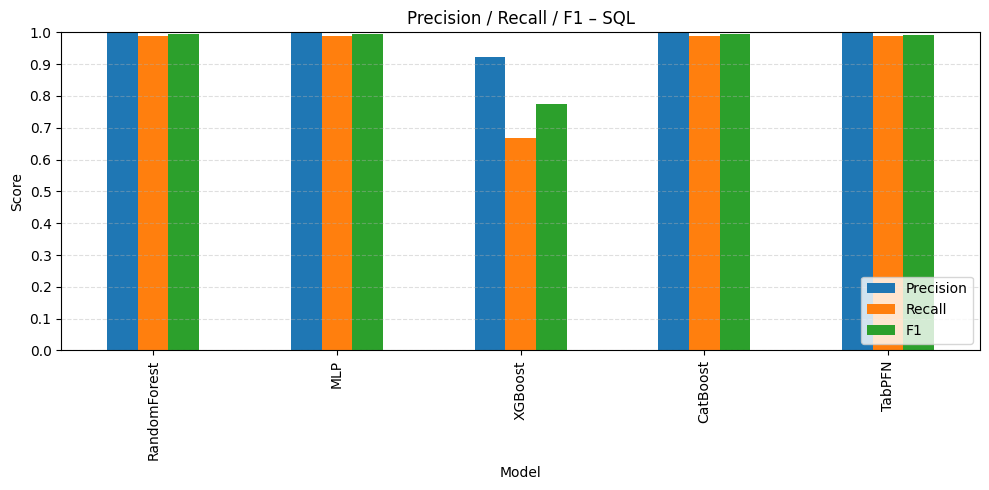

Saved: figures_metrics\PRF_by_model_SQL.pdf
Saved: figures_metrics\PRF_by_model_SQL.png


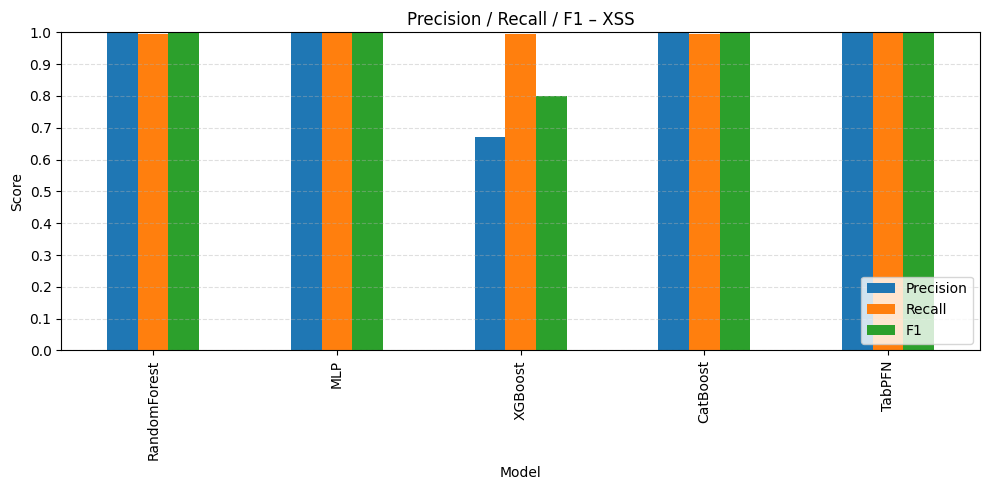

Saved: figures_metrics\PRF_by_model_XSS.pdf
Saved: figures_metrics\PRF_by_model_XSS.png

Fertig. Grafiken liegen in: C:\Users\nilsp\Github_Desktop\Machine-Learning-Modellen-zur-Erkennung-von-Web-Schwachstellen\figures_metrics


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pathlib import Path

LEGEND_LOC = "lower right"  # oder "lower left"
outdir = Path("figures_metrics"); outdir.mkdir(parents=True, exist_ok=True)

def _savefig(base, dpi=300):
    plt.tight_layout()
    plt.savefig(outdir / f"{base}.pdf", bbox_inches="tight")
    plt.savefig(outdir / f"{base}.png", dpi=dpi, bbox_inches="tight")
    plt.show()

# Falls df_results noch nicht im RAM ist:
try:
    df_results
except NameError:
    df_results = pd.read_csv("results_all.csv")

need = {"Model","Precision","Recall","F1"}
missing = need - set(df_results.columns)
if missing:
    raise ValueError(f"Fehlende Spalten: {missing}")

df = df_results.copy()
df["Dataset"]   = df["Model"].str.extract(r"-(SQL|XSS)$", expand=False)
df["BaseModel"] = df["Model"].str.replace(r"-(SQL|XSS)$", "", regex=True)

def _norm_name(s: str) -> str:
    u = str(s).strip().upper()
    if u in ("RF", "RANDOMFOREST"): return "RandomForest"
    if u in ("MLP",):               return "MLP"
    if u in ("XGB", "XGBOOST"):     return "XGBoost"
    if u in ("CAT", "CATBOOST"):    return "CatBoost"
    if u in ("TABPFN",):            return "TabPFN"
    return str(s).strip()

df["BaseModel"] = df["BaseModel"].map(_norm_name)
ORDER = ["RandomForest", "MLP", "XGBoost", "CatBoost", "TabPFN"]

def plot_prf_by_dataset(df_in: pd.DataFrame, dataset: str):
    df_ds = df_in[df_in["Dataset"] == dataset].copy()
    if df_ds.empty:
        print(f"Warnung: keine Zeilen für Dataset '{dataset}'.")
        return

    prf = (df_ds.set_index("BaseModel")[["Precision","Recall","F1"]]
                 .astype(float)
                 .reindex([m for m in ORDER if m in df_ds["BaseModel"].unique()]))

    ax = prf.plot(kind="bar", figsize=(10,5))
    ax.set_title(f"Precision / Recall / F1 – {dataset}")
    ax.set_ylabel("Score"); ax.set_xlabel("Model")

    # <<< 0,1-Schritte >>>
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    ax.legend(loc=LEGEND_LOC, frameon=True)

    base = f"PRF_by_model_{dataset}"
    _savefig(base, dpi=300)
    print("Saved:", outdir / f"{base}.pdf")
    print("Saved:", outdir / f"{base}.png")

plot_prf_by_dataset(df, "SQL")
plot_prf_by_dataset(df, "XSS")
print(f"\nFertig. Grafiken liegen in: {outdir.resolve()}")


# Hyperparameter-Tuning & Cross-Validation

## Feature und Modelle

In [42]:
from pathlib import Path
from joblib import Memory

# Feature-Builder (schnell & schlank)

def make_tfidf(max_features=20_000):
    return TfidfVectorizer(
        analyzer="char", ngram_range=(3,5),
        min_df=3, max_features=max_features,
        sublinear_tf=True, lowercase=False,
        dtype=np.float32
    )

# Cache, damit TF-IDF/SVD nicht in jedem Kandidaten neu gelernt werden müssen
memory = Memory(location="skcache", verbose=0)


#schlanke Suchräume
def pos_weight(y):
    pos = max(1, int(np.sum(y))); neg = max(1, int(len(y)-pos))
    return neg / pos

def grids(y):
    return {
        "RF": {
            "svd__n_components": [120, 150, 200],
            "clf__n_estimators": [300, 600],
            "clf__max_depth": [None, 20, 40],
            "clf__min_samples_split": [2, 5, 10],
            "clf__max_features": ["sqrt", None],
        },
        "MLP": {
            "svd__n_components": [120, 150, 200],
            "clf__hidden_layer_sizes": [(256,128), (512,256)],
            "clf__alpha": np.logspace(-5, -3, 3),
            "clf__learning_rate_init": [1e-4, 5e-4, 1e-3],
            "clf__batch_size": [64, 128],
        },
        "XGB": {
            "tfidf__max_features": [15_000, 20_000],
            "clf__n_estimators": [300, 500],
            "clf__max_depth": [4, 6, 8],
            "clf__learning_rate": [0.05, 0.1],
            "clf__subsample": [0.7, 1.0],
            "clf__colsample_bytree": [0.6, 1.0],
            "clf__reg_lambda": [0, 5],
            "clf__gamma": [0, 1],
            "clf__scale_pos_weight": [pos_weight(y)],
        },
        "CAT": {
            "tfidf__max_features": [15_000, 20_000],
            "clf__iterations": [400, 800],
            "clf__depth": [6, 8],
            "clf__learning_rate": [0.05, 0.1],
            "clf__l2_leaf_reg": [3, 5],
        }
    }


## HPO-Pipeline

In [43]:
def plot_results(results_df, title="Modellevaluation", metric="F1"):
    """Zeigt die Ergebnisse als Balkendiagramm an."""
    plt.figure(figsize=(12, 6))
    results_df.sort_values(by=metric, ascending=False).plot(
        x="Model", y=metric, kind="bar", legend=False, color="skyblue"
    )
    plt.title(title)
    plt.xlabel("Modelle")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [44]:
def get_hpo_subset(X, y, n=8000):
    """Erzeugt ein stratifiziertes Subset für HPO."""
    if len(y) <= n:
        return X, y
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=RANDOM_STATE)
    idx, _ = next(sss.split(np.zeros(len(y)), y))
    if hasattr(X, "iloc"):  # DataFrame oder Series
        return X.iloc[idx], np.asarray(y)[idx]
    else:
        return X[idx], np.asarray(y)[idx]


In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Pipelines
def pipe_rf_svd(max_features=20_000, n_comp=150):
    return Pipeline([
        ("tfidf", make_tfidf(max_features)),
        ("svd", TruncatedSVD(n_components=n_comp, random_state=RANDOM_STATE)),
        ("clf", RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE))
    ], memory=memory)

def pipe_mlp_svd(max_features=20_000, n_comp=150):
    return Pipeline([
        ("tfidf", make_tfidf(max_features)),
        ("svd", TruncatedSVD(n_components=n_comp, random_state=RANDOM_STATE)),
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", MLPClassifier(
            early_stopping=True, n_iter_no_change=8, max_iter=200,
            random_state=RANDOM_STATE
        ))
    ], memory=memory)

def pipe_xgb_sparse(max_features=20_000):
    return Pipeline([
        ("tfidf", make_tfidf(max_features)),
        ("clf", XGBClassifier(
            tree_method="hist",
            device=("cuda" if USE_CUDA else "cpu"),
            n_estimators=400,
            random_state=RANDOM_STATE,
            n_jobs=1  # Parallelisierung über CV, nicht im Estimator
        ))
    ], memory=memory)

def pipe_cat_sparse(max_features=20_000):
    return Pipeline([
        ("tfidf", make_tfidf(max_features)),
        ("clf", CatBoostClassifier(
            loss_function="Logloss",
            verbose=False,
            random_seed=RANDOM_STATE
        ))
    ], memory=memory)


TUNING: RandomForest (SQL)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[RF] best F1 (CV): 0.9943 in 1.1 min
[RF] best params: {'svd__n_components': 200, 'clf__n_estimators': 600, 'clf__min_samples_split': 5, 'clf__max_features': 'sqrt', 'clf__max_depth': 40}


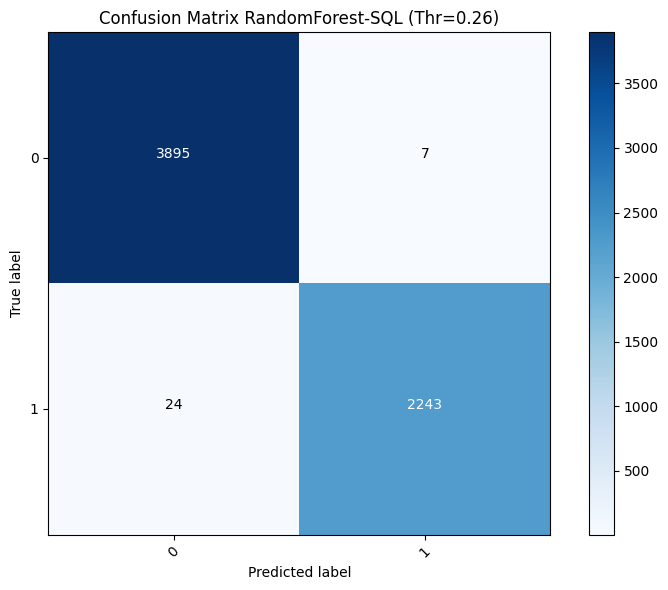

TEST: {'Model': 'RandomForest-SQL', 'Thr': 0.26, 'Precision': 0.9968888888888889, 'Recall': 0.9894133215703573, 'F1': 0.9931370378569847, 'FPR': 0.0017939518195797027, 'FNR': 0.0105866784296427}

TUNING: MLP (SQL)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[MLP] best F1 (CV): 0.9935 in 0.5 min
[MLP] best params: {'svd__n_components': 200, 'clf__learning_rate_init': 0.0005, 'clf__hidden_layer_sizes': (256, 128), 'clf__batch_size': 64, 'clf__alpha': np.float64(0.001)}


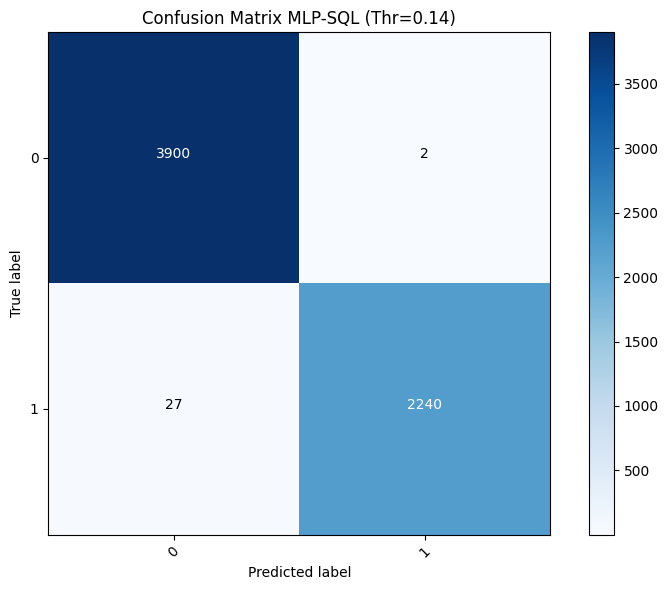

TEST: {'Model': 'MLP-SQL', 'Thr': 0.14, 'Precision': 0.9991079393398751, 'Recall': 0.9880899867666519, 'F1': 0.9935684187181193, 'FPR': 0.0005125576627370579, 'FNR': 0.011910013233348038}

TUNING: XGBoost (SQL)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[XGB] best F1 (CV): 0.8647 in 1.5 min
[XGB] best params: {'tfidf__max_features': 15000, 'clf__subsample': 0.7, 'clf__scale_pos_weight': 1.7210884353741496, 'clf__reg_lambda': 5, 'clf__n_estimators': 300, 'clf__max_depth': 8, 'clf__learning_rate': 0.1, 'clf__gamma': 1, 'clf__colsample_bytree': 1.0}


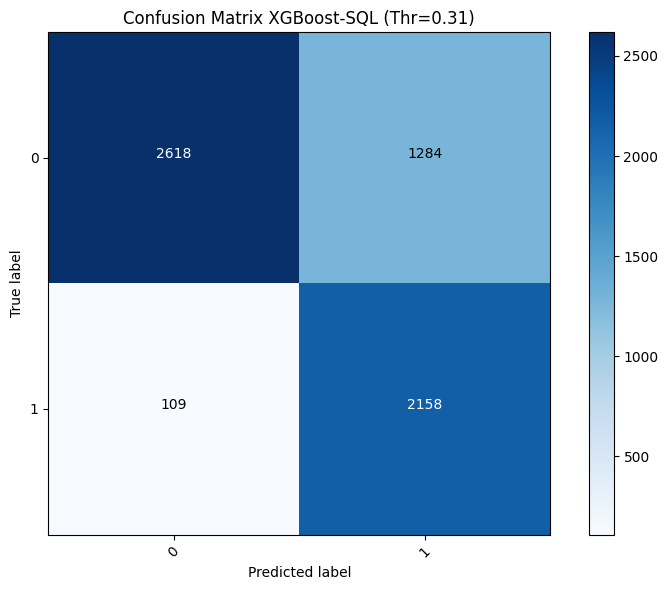

TEST: {'Model': 'XGBoost-SQL', 'Thr': 0.31, 'Precision': 0.6269610691458455, 'Recall': 0.9519188354653727, 'F1': 0.7559992993519005, 'FPR': 0.32906201947719116, 'FNR': 0.04808116453462726}

TUNING: CatBoost (SQL)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CAT] best F1 (CV): 0.9943 in 38.6 min
[CAT] best params: {'tfidf__max_features': 20000, 'clf__learning_rate': 0.05, 'clf__l2_leaf_reg': 3, 'clf__iterations': 800, 'clf__depth': 6}


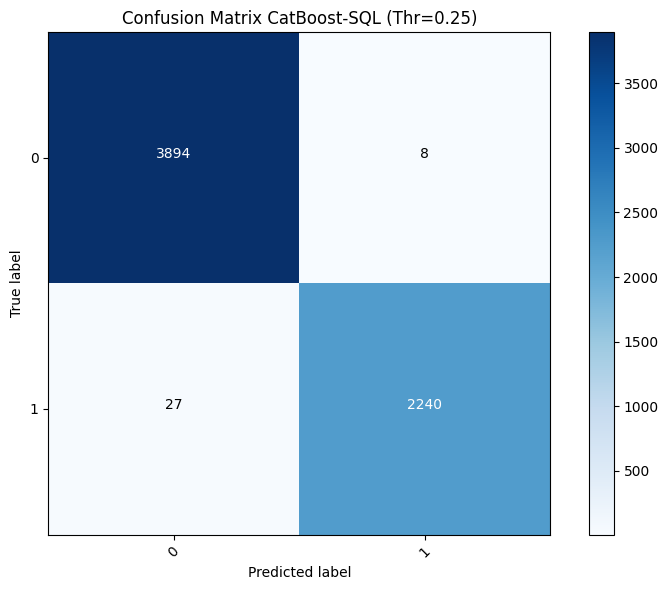

TEST: {'Model': 'CatBoost-SQL', 'Thr': 0.25, 'Precision': 0.99644128113879, 'Recall': 0.9880899867666519, 'F1': 0.9922480620155039, 'FPR': 0.0020502306509482316, 'FNR': 0.011910013233348038}

TUNING: RandomForest (XSS)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[RF] best F1 (CV): 0.9959 in 1.0 min
[RF] best params: {'svd__n_components': 150, 'clf__n_estimators': 600, 'clf__min_samples_split': 5, 'clf__max_features': 'sqrt', 'clf__max_depth': None}


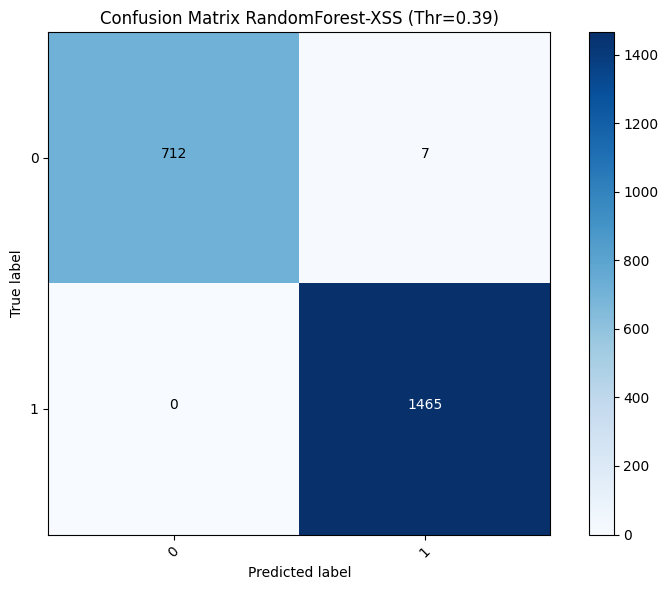

TEST: {'Model': 'RandomForest-XSS', 'Thr': 0.39, 'Precision': 0.9952445652173914, 'Recall': 1.0, 'F1': 0.9976166155941437, 'FPR': 0.009735744089012517, 'FNR': 0.0}

TUNING: MLP (XSS)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[MLP] best F1 (CV): 0.9953 in 0.8 min
[MLP] best params: {'svd__n_components': 200, 'clf__learning_rate_init': 0.0001, 'clf__hidden_layer_sizes': (512, 256), 'clf__batch_size': 64, 'clf__alpha': np.float64(0.001)}


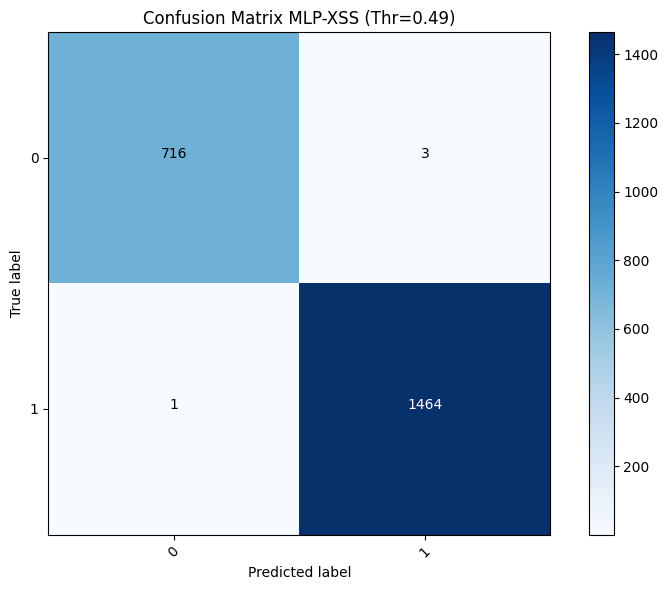

TEST: {'Model': 'MLP-XSS', 'Thr': 0.49, 'Precision': 0.9979550102249489, 'Recall': 0.9993174061433447, 'F1': 0.9986357435197817, 'FPR': 0.004172461752433936, 'FNR': 0.0006825938566552901}

TUNING: XGBoost (XSS)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[XGB] best F1 (CV): 0.9823 in 1.4 min
[XGB] best params: {'tfidf__max_features': 15000, 'clf__subsample': 0.7, 'clf__scale_pos_weight': 0.49086843086097653, 'clf__reg_lambda': 5, 'clf__n_estimators': 300, 'clf__max_depth': 8, 'clf__learning_rate': 0.1, 'clf__gamma': 1, 'clf__colsample_bytree': 1.0}


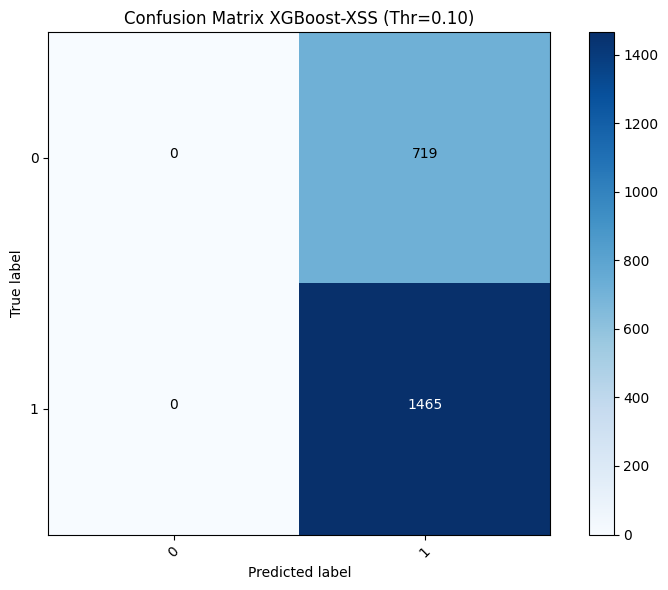

TEST: {'Model': 'XGBoost-XSS', 'Thr': 0.1, 'Precision': 0.6707875457875457, 'Recall': 1.0, 'F1': 0.8029597149904083, 'FPR': 1.0, 'FNR': 0.0}

TUNING: CatBoost (XSS)
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1200
max_resources_: 8000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1200
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 3600
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CAT] best F1 (CV): 0.9961 in 71.5 min
[CAT] best params: {'tfidf__max_features': 15000, 'clf__learning_rate': 0.05, 'clf__l2_leaf_reg': 3, 'clf__iterations': 800, 'clf__depth': 6}


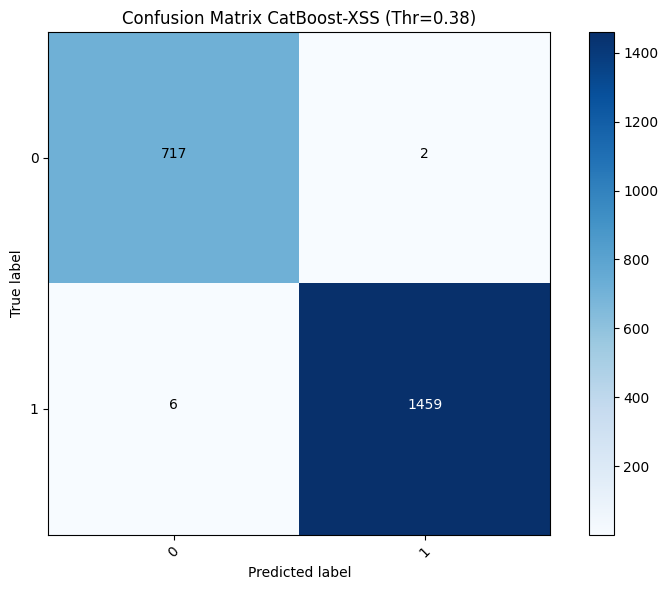

TEST: {'Model': 'CatBoost-XSS', 'Thr': 0.38, 'Precision': 0.998631074606434, 'Recall': 0.9959044368600682, 'F1': 0.9972658920027341, 'FPR': 0.0027816411682892906, 'FNR': 0.004095563139931741}


,Model,Thr,Precision,Recall,F1,FPR,FNR
0,RandomForest-SQL,0.26,0.996889,0.989413,0.993137,0.001794,0.010587
1,MLP-SQL,0.14,0.999108,0.988090,0.993568,0.000513,0.011910
2,XGBoost-SQL,0.31,0.626961,0.951919,0.755999,0.329062,0.048081
3,CatBoost-SQL,0.25,0.996441,0.988090,0.992248,0.002050,0.011910


,Model,Thr,Precision,Recall,F1,FPR,FNR
0,RandomForest-XSS,0.39,0.995245,1.000000,0.997617,0.009736,0.000000
1,MLP-XSS,0.49,0.997955,0.999317,0.998636,0.004172,0.000683
2,XGBoost-XSS,0.10,0.670788,1.000000,0.802960,1.000000,0.000000
3,CatBoost-XSS,0.38,0.998631,0.995904,0.997266,0.002782,0.004096


<Figure size 1200x600 with 0 Axes>

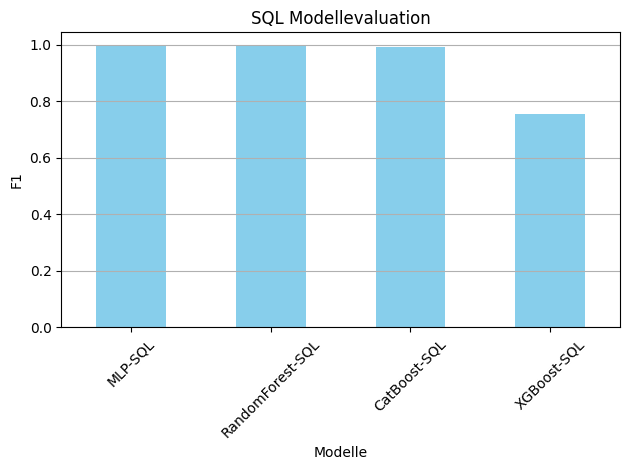

<Figure size 1200x600 with 0 Axes>

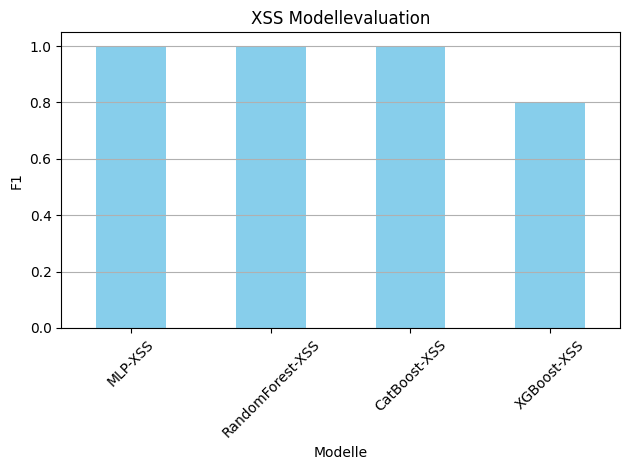

In [54]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support

# Gemeinsames CV-Objekt für faire Vergleiche
cv_shared = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Hilfsfunktion für Hyperparameter-Suche
def make_search(estimator, param_distributions, y_train, use_halving=True, cv=None):
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scorer = make_scorer(f1_score)
    if use_halving:
        n = len(y_train)
        min_res = max(200, int(0.15 * n))
        return HalvingRandomSearchCV(
            estimator=estimator,
            param_distributions=param_distributions,
            resource="n_samples",
            min_resources=min_res,
            max_resources="auto",
            factor=3,
            scoring=scorer,
            cv=cv,
            random_state=RANDOM_STATE,
            n_jobs=2,
            verbose=2
        )
    else:
        return RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_distributions,
            n_iter=10,
            scoring=scorer,
            cv=cv,
            random_state=RANDOM_STATE,
            n_jobs=2,
            verbose=2
        )

# Training + Suche + Refit + Threshold
def tune_one(name, X_train_txt, y_train, cv):
    if name == "RF":   pipe = pipe_rf_svd()
    elif name == "MLP": pipe = pipe_mlp_svd()
    elif name == "XGB": pipe = pipe_xgb_sparse()
    elif name == "CAT": pipe = pipe_cat_sparse()
    else: raise ValueError(name)

    # Teilmenge für HPO
    X_hpo, y_hpo = get_hpo_subset(X_train_txt, y_train, n=8000)
    space = grids(y_hpo)[name]
    search = make_search(pipe, space, y_hpo, use_halving=True, cv=cv)

    t0 = time.perf_counter()
    search.fit(X_hpo, y_hpo)
    dt = time.perf_counter() - t0
    print(f"[{name}] best F1 (CV): {search.best_score_:.4f} in {dt/60:.1f} min")
    print(f"[{name}] best params:", search.best_params_)

    best = clone(search.best_estimator_)
    best.fit(X_train_txt, y_train)
    return best, search.best_params_, search.best_score_, dt

# Threshold-Optimierung + Testauswertung
def eval_on_test(name, est, X_train_txt, y_train, X_test_txt, y_test, tune_threshold=True):
    thr = 0.5
    if tune_threshold and hasattr(est, "predict_proba"):
        X_tr2, X_val, y_tr2, y_val = train_test_split(X_train_txt, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE)
        est_for_thr = est
        est_for_thr.fit(X_tr2, y_tr2)
        p = est_for_thr.predict_proba(X_val)[:, 1]
        grid = np.linspace(0.1, 0.9, 81)
        thr = float(grid[int(np.argmax([f1_score(y_val, (p >= t).astype(int)) for t in grid]))])

    y_pred = (est.predict_proba(X_test_txt)[:,1] >= thr).astype(int) if hasattr(est, "predict_proba") else est.predict(X_test_txt)
    plot_confusion_matrix(y_test, y_pred, labels=[0, 1], title=f"Confusion Matrix {name} (Thr={thr:.2f})")
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = float(fp / (fp + tn)) if (fp + tn) else 0.0
    fnr = float(fn / (fn + tp)) if (fn + tp) else 0.0
    return dict(Model=name, Thr=thr, Precision=p, Recall=r, F1=f1, FPR=fpr, FNR=fnr)

# Ausführung mit übergebenem Split
def run_fast_from_split(X_train_txt, X_test_txt, y_train, y_test, ds_name, cv):
    results = []
    for short, label in [("RF", "RandomForest"), ("MLP", "MLP"), ("XGB", "XGBoost"), ("CAT", "CatBoost")]:
        print("\n" + "=" * 60)
        print(f"TUNING: {label} ({ds_name})")
        best_est, params, best_cv, dt = tune_one(short, X_train_txt, y_train, cv=cv)
        res = eval_on_test(f"{label}-{ds_name}", best_est, X_train_txt, y_train, X_test_txt, y_test)
        print("TEST:", res)
        results.append(res)
    return pd.DataFrame(results)

# Anwendung auf beide Datensätze
sql_res = run_fast_from_split(X_train_sql, X_test_sql, y_train_sql, y_test_sql, ds_name="SQL", cv=cv_shared)
xss_res = run_fast_from_split(X_train_xss, X_test_xss, y_train_xss, y_test_xss, ds_name="XSS", cv=cv_shared)

display(sql_res)
display(xss_res)
plot_results(sql_res, title="SQL Modellevaluation", metric="F1")
plot_results(xss_res, title="XSS Modellevaluation", metric="F1")

C:\Users\nilsp\AppData\Local\Temp\ipykernel_20388\4223905871.py:86: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = dfc.pivot_table(index="BaseModel", columns="Source", values="F1", aggfunc="mean")


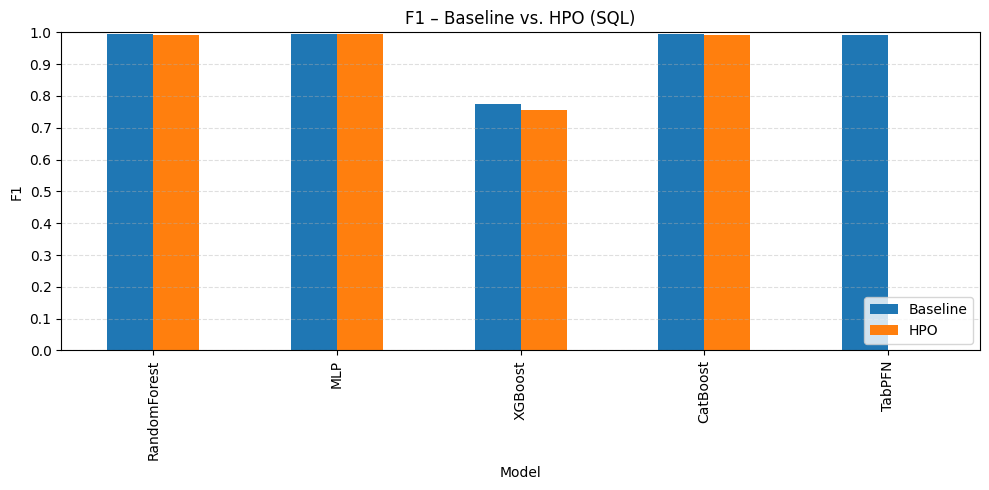

Saved: C:\Users\nilsp\Github_Desktop\Machine-Learning-Modellen-zur-Erkennung-von-Web-Schwachstellen\figures_metrics\F1_compare_SQL.pdf
Saved: C:\Users\nilsp\Github_Desktop\Machine-Learning-Modellen-zur-Erkennung-von-Web-Schwachstellen\figures_metrics\F1_compare_SQL.png


C:\Users\nilsp\AppData\Local\Temp\ipykernel_20388\4223905871.py:86: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = dfc.pivot_table(index="BaseModel", columns="Source", values="F1", aggfunc="mean")


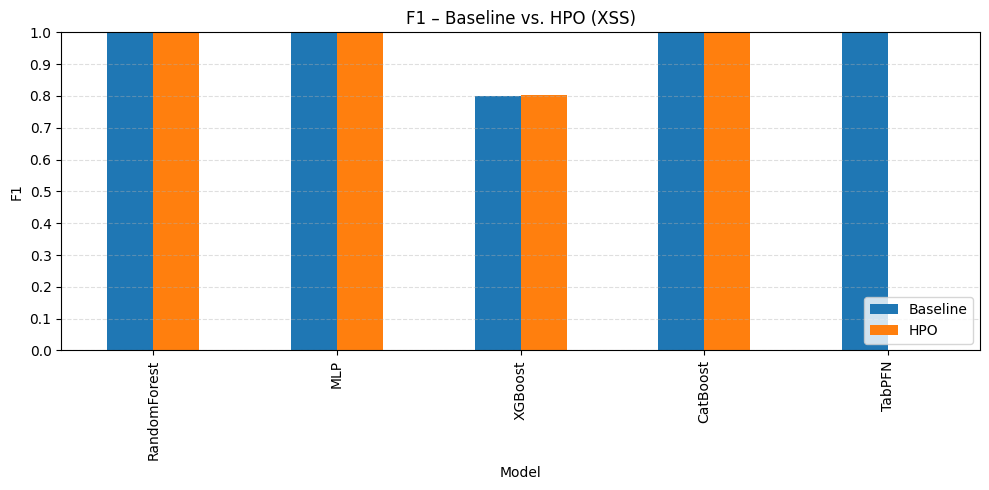

Saved: C:\Users\nilsp\Github_Desktop\Machine-Learning-Modellen-zur-Erkennung-von-Web-Schwachstellen\figures_metrics\F1_compare_XSS.pdf
Saved: C:\Users\nilsp\Github_Desktop\Machine-Learning-Modellen-zur-Erkennung-von-Web-Schwachstellen\figures_metrics\F1_compare_XSS.png

Fertig. Grafiken liegen in: C:\Users\nilsp\Github_Desktop\Machine-Learning-Modellen-zur-Erkennung-von-Web-Schwachstellen\figures_metrics


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pathlib import Path

# ----- Einstellungen -----
LEGEND_LOC = "lower right"
ORDER = ["RandomForest", "MLP", "XGBoost", "CatBoost", "TabPFN"]
outdir = Path("figures_metrics"); outdir.mkdir(parents=True, exist_ok=True)

def _savefig(base, dpi=300):
    plt.tight_layout()
    plt.savefig(outdir / f"{base}.pdf", bbox_inches="tight")
    plt.savefig(outdir / f"{base}.png", dpi=dpi, bbox_inches="tight")
    plt.show()

def _norm_name(s: str) -> str:
    u = str(s).strip().upper()
    if u in ("RF","RANDOMFOREST"): return "RandomForest"
    if u in ("MLP",):              return "MLP"
    if u in ("XGB","XGBOOST"):     return "XGBoost"
    if u in ("CAT","CATBOOST"):    return "CatBoost"
    if u in ("TABPFN",):           return "TabPFN"
    return str(s).strip()

# ---------- Baseline laden/normalisieren ----------
try:
    df_results
except NameError:
    df_results = pd.read_csv("results_all.csv")

need = {"Model","F1"}
missing = need - set(df_results.columns)
if missing:
    raise ValueError(f"Fehlende Spalten in results_all.csv: {missing}")

df_first = df_results.copy()
df_first["Dataset"]   = df_first["Model"].str.extract(r"-(SQL|XSS)$", expand=False)
df_first["BaseModel"] = df_first["Model"].str.replace(r"-(SQL|XSS)$", "", regex=True).map(_norm_name)
df_first = df_first[["Dataset","BaseModel","F1"]].dropna()

# ---------- HPO-Ergebnisse zusammenführen ----------
frames = []
if "sql_res" in globals() and isinstance(sql_res, pd.DataFrame):
    frames.append(sql_res.copy())
if "xss_res" in globals() and isinstance(xss_res, pd.DataFrame):
    frames.append(xss_res.copy())

if not frames:
    raise RuntimeError("Keine HPO-Frames gefunden. Stelle sicher, dass sql_res/xss_res DataFrames sind.")

df_hpo_raw = pd.concat(frames, ignore_index=True)

# Falls F1 in HPO fehlt, aus Precision+Recall berechnen
if "F1" not in df_hpo_raw.columns and {"Precision","Recall"} <= set(df_hpo_raw.columns):
    pr = df_hpo_raw[["Precision","Recall"]].astype(float)
    df_hpo_raw["F1"] = (2*pr["Precision"]*pr["Recall"])/(pr["Precision"]+pr["Recall"]).fillna(0.0)

# Model → Dataset & BaseModel
if "Model" not in df_hpo_raw.columns:
    raise ValueError("HPO-Resultate haben keine Spalte 'Model'.")

df_hpo = df_hpo_raw.copy()
df_hpo["Dataset"]   = df_hpo["Model"].str.extract(r"-(SQL|XSS)$", expand=False)
df_hpo["BaseModel"] = df_hpo["Model"].str.replace(r"-(SQL|XSS)$", "", regex=True).map(_norm_name)
df_hpo = df_hpo[["Dataset","BaseModel","F1"]].dropna()

# ---------- Plot: 2 Balken (Baseline vs HPO) je Dataset ----------
def plot_f1_compare(dataset: str):
    d1 = df_first[df_first["Dataset"] == dataset].copy()
    d1["Source"] = "Baseline"

    d2 = df_hpo[df_hpo["Dataset"] == dataset].copy()
    d2["Source"] = "HPO"

    dfc = pd.concat([d1, d2], ignore_index=True)
    if dfc.empty:
        print(f"Warnung: Keine Daten für {dataset}.")
        return

    # feste Modell-Reihenfolge, nur vorhandene Modelle anzeigen
    present = [m for m in ORDER if m in dfc["BaseModel"].unique()]
    dfc["BaseModel"] = pd.Categorical(dfc["BaseModel"], categories=present, ordered=True)

    pivot = dfc.pivot_table(index="BaseModel", columns="Source", values="F1", aggfunc="mean")
    # beide Säulen sicherstellen (falls TabPFN nur in erster Pipeline vorhanden ist)
    for col in ["Baseline","HPO"]:
        if col not in pivot.columns:
            pivot[col] = np.nan
    pivot = pivot.loc[present, ["Baseline","HPO"]]

    ax = pivot.plot(kind="bar", figsize=(10,5))
    ax.set_title(f"F1 – Baseline vs. HPO ({dataset})")
    ax.set_xlabel("Model"); ax.set_ylabel("F1")

    # y-Achse: 0..1 in 0.1-Schritten
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.legend(loc=LEGEND_LOC, frameon=True)

    base = f"F1_compare_{dataset}"
    _savefig(base, dpi=300)
    print("Saved:", (outdir / f"{base}.pdf").resolve())
    print("Saved:", (outdir / f"{base}.png").resolve())

plot_f1_compare("SQL")
plot_f1_compare("XSS")
print("\nFertig. Grafiken liegen in:", outdir.resolve())


In [ ]:
# Combine results and tag with dataset names
sql_res["Dataset"] = "SQL"
xss_res["Dataset"] = "XSS"

df_all = pd.concat([sql_res, xss_res], ignore_index=True)

# Anzeigen
display(df_all)

# LLM-Vergleich

In [ ]:
#%pip show openai
#%pip install openai==0.28
#%pip install --upgrade openai
#%pip install python-dotenv
#%pip install mistralai tenacity
#%pip install mistralai 
#%pip show mistralai

## Metriken

In [ ]:


def _safe_div(num, den):
    return float(num/den) if den else 0.0

def compute_binary_metrics(y_true, y_pred):
    """Berechnet binäre Klassifikationsmetriken für positive Klasse (1 = malicious)."""
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    TP = int(np.sum((y_true == 1) & (y_pred == 1)))
    TN = int(np.sum((y_true == 0) & (y_pred == 0)))
    FP = int(np.sum((y_true == 0) & (y_pred == 1)))
    FN = int(np.sum((y_true == 1) & (y_pred == 0)))

    precision = _safe_div(TP, TP + FP)
    recall    = _safe_div(TP, TP + FN)
    f1        = _safe_div(2*precision*recall, precision + recall) if (precision+recall) else 0.0
    fpr       = _safe_div(FP, FP + TN)
    specificity = _safe_div(TN, TN + FP)
    accuracy  = _safe_div(TP + TN, TP + TN + FP + FN)

    return {
        "N_valid": int(len(y_true)),
        "Support_pos(1)": int(np.sum(y_true == 1)),
        "Support_neg(0)": int(np.sum(y_true == 0)),
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "FPR": fpr,
        "Specificity": specificity,
    }

def confusion_matrix_df(y_true, y_pred):
    """Erstellt eine Pandas-Confusion-Matrix."""
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    cm = pd.crosstab(pd.Series(y_true, name="True"),
                     pd.Series(y_pred, name="Pred"),
                     dropna=False)
    for cls in [0,1]:
        if cls not in cm.index: cm.loc[cls] = 0
        if cls not in cm.columns: cm[cls] = 0
    return cm.sort_index().sort_index(axis=1)

def metrics_for_dataset(df: pd.DataFrame, name: str):
    """Wrapper: zieht y_true / y_pred aus df und berechnet Metriken + Confusion Matrix."""
    valid = df.dropna(subset=["Pred"]).copy()
    if valid.empty:
        return name, pd.DataFrame([{"Dataset": name, "N_valid": 0}]), pd.DataFrame()
    y_true = valid["True"].astype(int).values
    y_pred = valid["Pred"].astype(int).values
    m = compute_binary_metrics(y_true, y_pred)
    m["Dataset"] = name
    cm = confusion_matrix_df(y_true, y_pred)
    return name, pd.DataFrame([m]), cm


# Prompts

In [ ]:
import os, re, time, json, requests
from collections import deque
from tenacity import retry, stop_after_attempt, retry_if_exception_type, wait_exponential
from pathlib import Path

API_URL = "https://api.mistral.ai/v1/chat/completions"
MISTRAL_MODEL = os.getenv("MISTRAL_MODEL", "mistral-small-latest")
SYSTEM_PROMPT = (
    "You are a strict binary security classifier. "
    "Classify the given text as exactly one token: 'benign' or 'malicious'. "
    "Do not add punctuation or explanations."
)

class Mistral429(Exception):
    def __init__(self, response):
        self.response = response
        super().__init__(f"429 Too Many Requests: {response.text[:200]}")

def _headers():
    api_key = os.getenv("MISTRAL_API_KEY", "").strip().strip('"').strip("'")
    return {"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"}

@retry(
    retry=retry_if_exception_type((requests.HTTPError, Mistral429)),
    wait=wait_exponential(multiplier=1, min=1, max=60),
    stop=stop_after_attempt(7),
    reraise=True,
)
def classify_with_mistral(text: str) -> str:
    data = {
        "model": MISTRAL_MODEL,
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": f"Classify the following text as 'benign' or 'malicious': {text}"},
        ],
        "temperature": 0.0,
        "max_tokens": 4
    }
    r = requests.post(API_URL, headers=_headers(), json=data, timeout=30)
    if r.status_code == 429:
        ra = r.headers.get("Retry-After")
        if ra:
            try:
                time.sleep(float(ra))
            except ValueError:
                pass
        raise Mistral429(r)
    r.raise_for_status()
    out = r.json()["choices"][0]["message"]["content"].strip()
    m = re.search(r"\b(benign|malicious)\b", out, flags=re.IGNORECASE)
    return (m.group(1) if m else out).lower()

def evaluate_llm_on_samples(
    X_test, y_test, sample_n=50,
    calls_per_minute=12,         # (z.B. 10–12)
    checkpoint_path="results/mistral_checkpoint.json",
):
    os.makedirs(Path(checkpoint_path).parent, exist_ok=True)

    # ===== DEDUPLICATION =====
    texts = list(X_test.iloc[:sample_n])
    unique_texts = list(dict.fromkeys(texts))  # preserves order; removes duplicates

    # ===== LOAD CHECKPOINT =====
    cache = {}
    if Path(checkpoint_path).exists():
        try:
            cache = json.loads(Path(checkpoint_path).read_text(encoding="utf-8"))
        except Exception:
            cache = {}

    # ===== RATE LIMITER (leaky bucket) =====
    window = deque()  # timestamps der letzten Calls
    def pace():
        now = time.monotonic()
        window.append(now)
        while window and (now - window[0]) > 60:
            window.popleft()
        if len(window) > calls_per_minute:
            sleep_s = 60 - (now - window[0]) + 0.05
            time.sleep(max(0.0, sleep_s))

    # ===== CLASSIFY UNIQUE TEXTS WITH CACHING & CHECKPOINTING =====
    for idx, t in enumerate(unique_texts, 1):
        if t in cache and cache[t] in ("benign", "malicious"):
            continue
        pace()
        try:
            cache[t] = classify_with_mistral(t)
        except Mistral429 as e:
            # Bei hartnäckigen 429: lange Pause, dann nochmal probieren
            time.sleep(65)
            pace()
            cache[t] = classify_with_mistral(t)
        # sofort checkpointen (resumable)
        Path(checkpoint_path).write_text(json.dumps(cache, ensure_ascii=False), encoding="utf-8")

    # ===== MAP BACK TO FULL LIST =====
    mapping = {"benign": 0, "malicious": 1}
    results = []
    for i, (text, true_label) in enumerate(zip(X_test.iloc[:sample_n], y_test[:sample_n])):
        t0 = time.perf_counter()
        pred_str = cache.get(text, np.nan)
        t_elapsed = time.perf_counter() - t0
        pred_label = mapping.get(str(pred_str).lower(), np.nan) if isinstance(pred_str, str) else np.nan
        results.append({
            "Index": i,
            "Text": text,
            "True": true_label,
            "Pred": pred_label,
            "LLM_response": pred_str,
            "Time": t_elapsed
        })
    return results


In [ ]:
# Evaluation mit dem Mistral-LLM
results_llm_sql = evaluate_llm_on_samples(X_test_sql, y_test_sql, sample_n=50)
results_llm_xss = evaluate_llm_on_samples(X_test_xss, y_test_xss, sample_n=50)

# Ergebnisse in DataFrames packen
df_llm_sql = pd.DataFrame(results_llm_sql)
df_llm_xss = pd.DataFrame(results_llm_xss)

# Kurzer Check
print("SQL Evaluation:")
display(df_llm_sql.head())
print("XSS Evaluation:")
display(df_llm_xss.head())



In [ ]:
# Annahme: df_llm_sql und df_llm_xss existieren bereits (aus evaluate_llm_on_samples)

name_sql, metrics_sql_df, cm_sql = metrics_for_dataset(df_llm_sql, "SQL")
name_xss, metrics_xss_df, cm_xss = metrics_for_dataset(df_llm_xss, "XSS")

print("=== Metrics: SQL ===")
display(metrics_sql_df.style.format({
    "Accuracy":"{:.4f}", "Precision":"{:.4f}", "Recall":"{:.4f}", "F1":"{:.4f}",
    "FPR":"{:.4f}", "Specificity":"{:.4f}"
}))
print("Confusion Matrix (SQL):")
display(cm_sql)

print("\n=== Metrics: XSS ===")
display(metrics_xss_df.style.format({
    "Accuracy":"{:.4f}", "Precision":"{:.4f}", "Recall":"{:.4f}", "F1":"{:.4f}",
    "FPR":"{:.4f}", "Specificity":"{:.4f}"
}))
print("Confusion Matrix (XSS):")
display(cm_xss)

